In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import numpy as np

2024-07-29 01:30:39.781372: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAZE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAZE_SIZE,IMAZE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
len(dataset)


68

### By using tensorflow input pipeline we load our images from directory as batches. As we took batch size is 32 the resulted dataset has length 68 which means 68 batches and each batch has 32 images in total 68*32 equals 2152 images belongs to 3 classes  

In [5]:
class_names=dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, label_batch in dataset.take(1):
    for i in label_batch:
        print(class_names[i])

Potato___healthy
Potato___Late_blight
Potato___Late_blight
Potato___Early_blight
Potato___Late_blight
Potato___Late_blight
Potato___Early_blight
Potato___Early_blight
Potato___healthy
Potato___Late_blight
Potato___Early_blight
Potato___Late_blight
Potato___Early_blight
Potato___Late_blight
Potato___Early_blight
Potato___Early_blight
Potato___Early_blight
Potato___Late_blight
Potato___Late_blight
Potato___Late_blight
Potato___Early_blight
Potato___Late_blight
Potato___Early_blight
Potato___Early_blight
Potato___Late_blight
Potato___Late_blight
Potato___healthy
Potato___Early_blight
Potato___Early_blight
Potato___Late_blight
Potato___Early_blight
Potato___Late_blight


2024-07-29 01:30:50.861174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


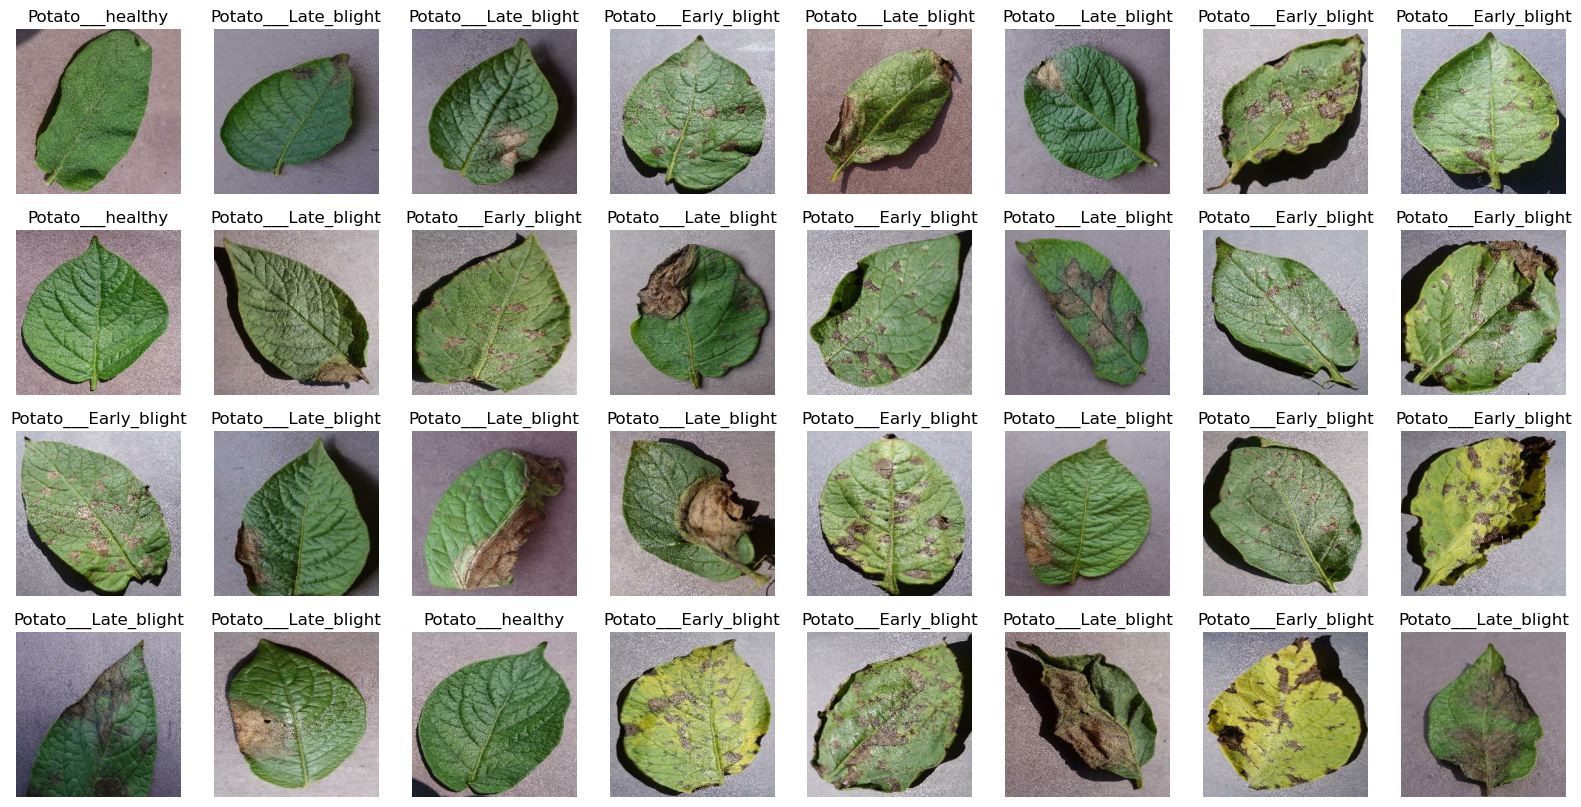

In [7]:
plt.figure(figsize=(20,10))
for i in range(BATCH_SIZE):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(class_names[label_batch[i]])


In [8]:
def tf_dataset_partitions(ds,training_size=0.8,val_size=0.1,testing_size=0.1,shuffle=True,shuffle_size=10000):
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_len=int(len(ds)*training_size)
    val_len=int(len(ds)*val_size)
    train_ds=ds.take(train_len)
    val_ds=ds.skip(train_len).take(val_len)
    test_ds=ds.skip(train_len).skip(val_len)
    
    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds=tf_dataset_partitions(dataset)
print(len(train_ds),len(val_ds),len(test_ds))

54 6 8


In [10]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_nd_rescale = tf.keras.Sequential([
   layers.Resizing(IMAZE_SIZE,IMAZE_SIZE),
    layers.Rescaling(1.0/255)
])

In [12]:
data_augmentation= tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.3)
])

In [13]:
input_shape=(IMAZE_SIZE,IMAZE_SIZE,CHANNELS)

model= models.Sequential([
    resize_nd_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(10,activation='relu'),
    layers.Dense(3,activation='softmax')
])

model.build(input_shape=(BATCH_SIZE,IMAZE_SIZE,IMAZE_SIZE,CHANNELS))

/Users/lucky_2711/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 3)                │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,379 (1.06 MB)

 Trainable params: 278,379 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    batch_size=BATCH_SIZE,
    validation_data=val_ds
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.4950 - loss: 0.9421 - val_accuracy: 0.6354 - val_loss: 0.8413
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.6816 - loss: 0.6876 - val_accuracy: 0.8281 - val_loss: 0.5129
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.8201 - loss: 0.3979 - val_accuracy: 0.8802 - val_loss: 0.3541
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.8742 - loss: 0.3027 - val_accuracy: 0.8542 - val_loss: 0.2716
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.8866 - loss: 0.2625 - val_accuracy: 0.9583 - val_loss: 0.1768
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.9205 - loss: 0.2080 - val_accuracy: 0.9427 - val_loss: 0.1264
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9267 - loss: 0.1766 - val_accuracy: 0.9219 - val_loss: 0.1874
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.9370 - loss: 0.1601 - val_accuracy: 0.7760 - v

In [17]:
score = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 666ms/step - accuracy: 0.9839 - loss: 0.0837


actual_label Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
predicted_label: Potato___Late_blight


2024-07-29 02:55:38.452069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


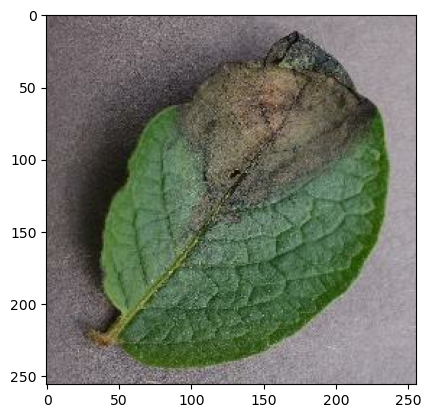

In [18]:
for image_batch, label_batch in dataset.take(1):
    image_1=image_batch[0].numpy().astype("uint8")
    class_name=class_names[label_batch[0].numpy()]
    print("actual_label",class_name)
    plt.imshow(image_1)
    predictions=model.predict(image_batch)
    print("predicted_label:",class_names[np.argmax(predictions[0])])

In [19]:
def predict(model,img):
    img_arr=tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_arr=tf.expand_dims(img_arr,0) #creates a batch
    
    predictions = model.predict(img_arr)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    
    confidence = round(100*(np.max(predictions[0])),2)
    
    return predicted_class,confidence
    
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━

2024-07-29 03:26:49.037630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


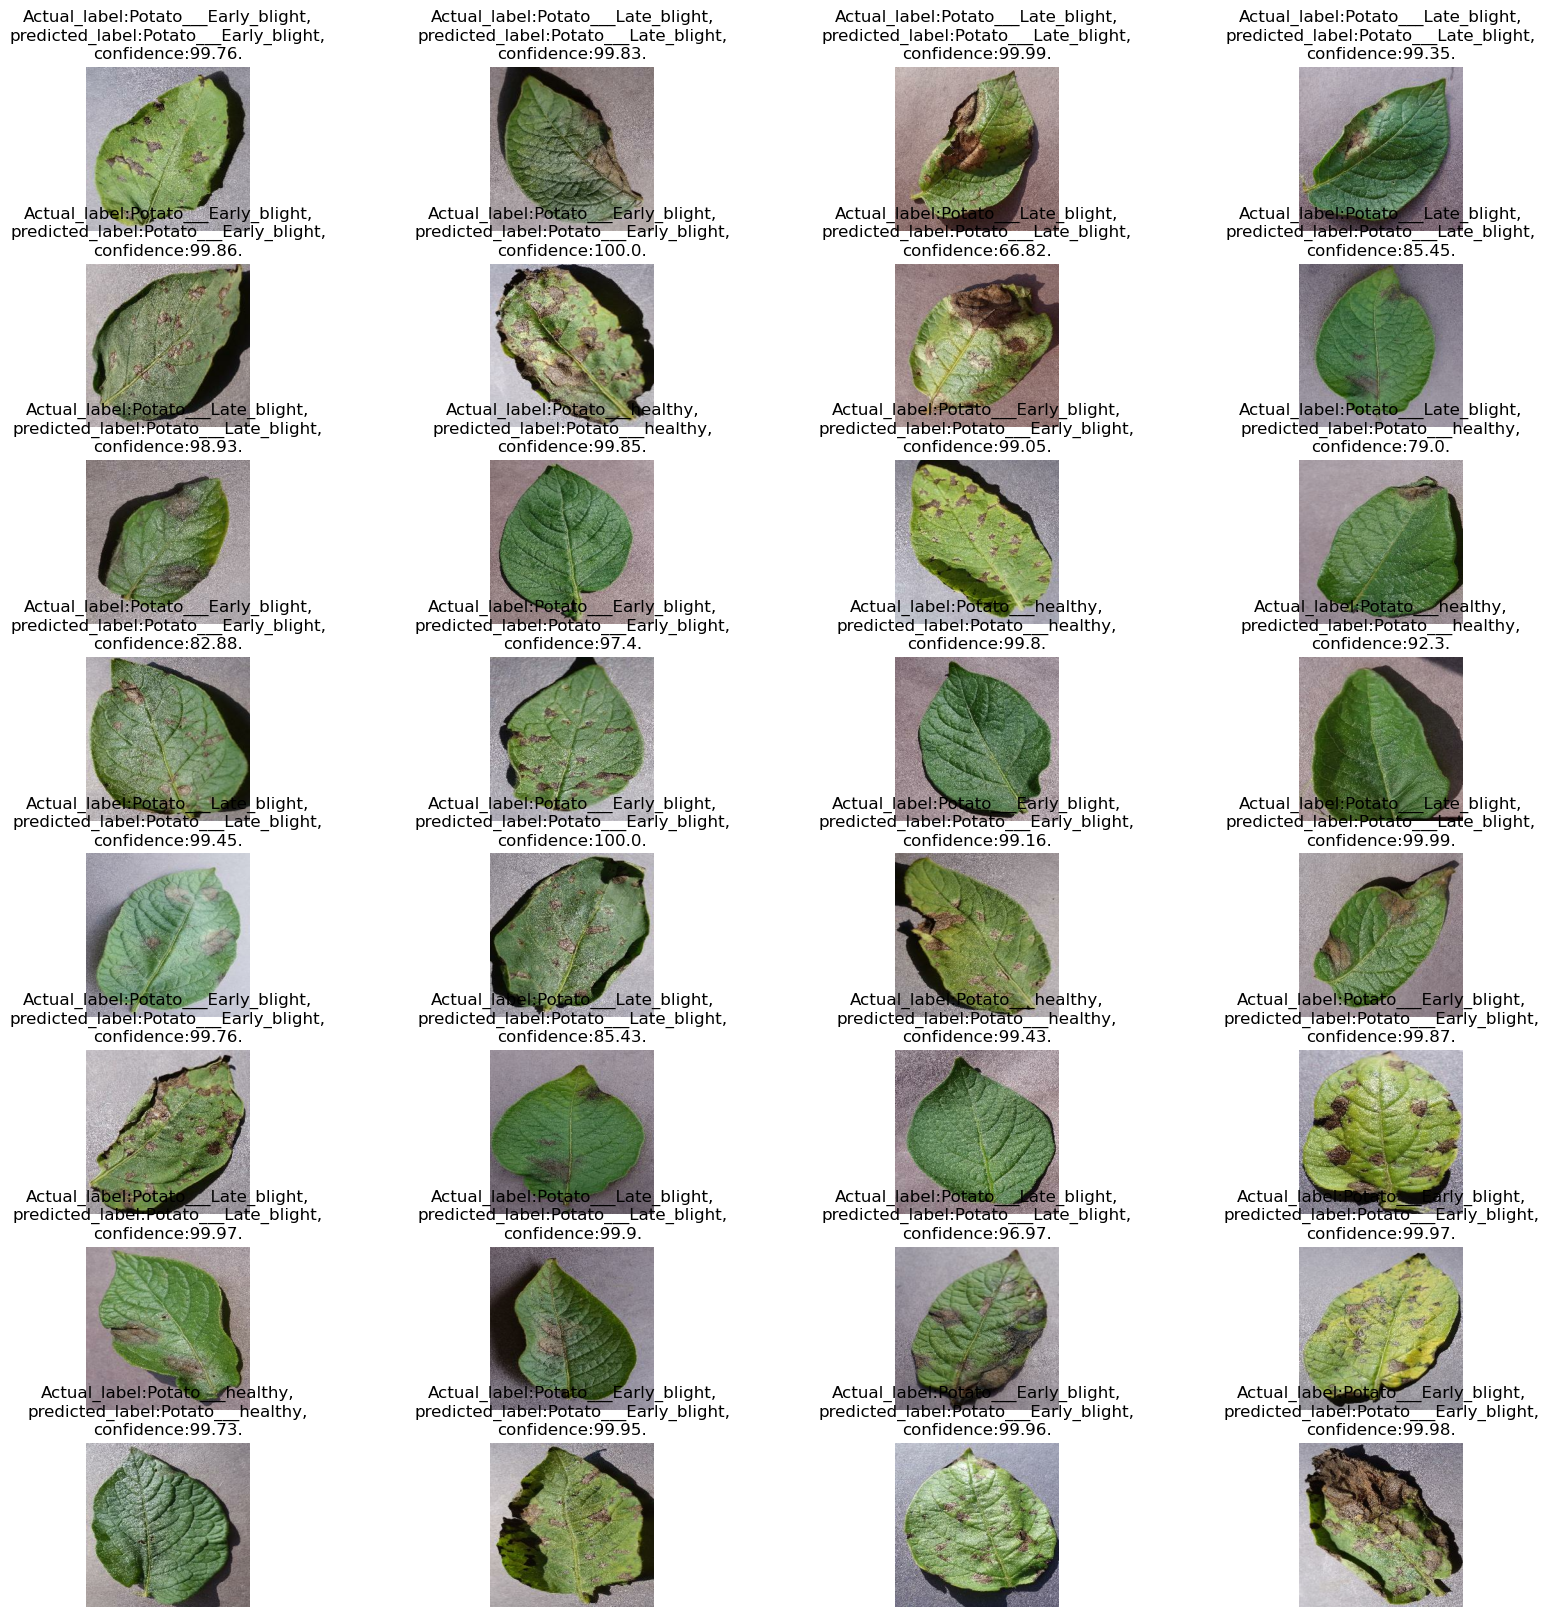

In [30]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in test_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8')) 
        plt.axis('off')
        
        actual_class_label=class_names[label_batch[i]]
        predicted_class,confidence=predict(model,image_batch[i].numpy())
        
        plt.title(f"Actual_label:{actual_class_label},\npredicted_label:{predicted_class},\nconfidence:{confidence}.")
        
    